In [43]:
import json

import collections
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
var_pairs = pd.read_parquet("hackathon_files_for_participants_ozon/train_pairs.parquet")
products_all = pd.read_parquet("hackathon_files_for_participants_ozon/train_data.parquet")

In [4]:
products_all = products_all[
    ['name', 'categories', 'characteristic_attributes_mapping', 'variantid']
].dropna()
products_all.categories = products_all.categories.apply(lambda x: json.loads(x)["3"])

In [5]:
products_all.shape

(457036, 4)

In [6]:
product_pairs = var_pairs.merge(
    products_all.add_suffix('1'),
    on="variantid1"
).merge(
    products_all.add_suffix('2'),
    on="variantid2"
)

In [7]:
identcial_pairs = product_pairs[product_pairs['target'] == 1]
various_pairs = product_pairs[product_pairs['target'] == 0]

In [8]:
identcial_pairs.shape, various_pairs.shape

((134989, 9), (171521, 9))

In [ ]:
%%time

vectorizer = TfidfVectorizer()
   
count_not_matched_attr_for_various_pairs = collections.Counter(
    attr_name 
    if (
        (
            (' '.join(json.loads(attributes1.lower())[attr_name])) != (
             ' '.join(json.loads(attributes2.lower())[attr_name]))
        ) and (
            cosine_similarity(
                *vectorizer.fit_transform(
                    [
                        ' '.join(json.loads(attributes1.lower())[attr_name]) + 'tr',
                        ' '.join(json.loads(attributes2.lower())[attr_name]) + 'tr'
                    ]
                )
            ) < 0.5
        )
    ) else 'matched'
    for (attributes1, attributes2) in zip(various_pairs.characteristic_attributes_mapping1, 
                                          various_pairs.characteristic_attributes_mapping2)
        for attr_name in set(json.loads(attributes1.lower())) & set(json.loads(attributes2.lower()))
)

In [ ]:
del count_not_matched_attr_for_various_pairs['matched']

In [ ]:
%%time
count_not_matched_attr_for_ident_pairs = collections.Counter(
    attr_name 
      if (
        (
            (' '.join(json.loads(attributes1.lower())[attr_name])) != (
             ' '.join(json.loads(attributes2.lower())[attr_name]))
        ) and (
            cosine_similarity(
                *vectorizer.fit_transform(
                    [
                        ' '.join(json.loads(attributes1.lower())[attr_name]) + 'tr',
                        ' '.join(json.loads(attributes2.lower())[attr_name]) + 'tr'
                    ]
                )
            ) < 0.5
        )
    ) else 'matched'

    for (attributes1, attributes2) in zip(identcial_pairs.characteristic_attributes_mapping1, 
                                          identcial_pairs.characteristic_attributes_mapping2)
        for attr_name in set(json.loads(attributes1.lower())) & set(json.loads(attributes2.lower()))
)

In [ ]:
del count_not_matched_attr_for_ident_pairs['matched']

In [ ]:
%%time
count_not_matched_attr_for_ident_pairs_norm = {
    attr: freq / attr_freq[attr]
    for attr, freq in count_not_matched_attr_for_indent_pairs.items()
}
count_not_matched_attr_for_ident_pairs_norm = dict(
    sorted(count_not_matched_attr_for_ident_pairs_norm.items(),
           key=lambda x: x[1],
           reverse=True)
)
count_not_matched_attr_for_various_pairs_norm = {
    attr: freq / attr_freq[attr]
    for attr, freq in count_not_matched_attr_for_various_pairs.items()
}
count_not_matched_attr_for_various_pairs_norm = dict(
    sorted(count_not_matched_attr_for_various_pairs_norm.items(),
           key=lambda x: x[1],
           reverse=True)
)

In [ ]:
with open('count_not_matched_attr_for_various_pairs_norm.json', 'w') as f:
    json.dump(count_not_matched_attr_for_various_pairs_norm, f, sort_keys=True)

with open('count_not_matched_attr_for_indent_pairs_norm.json', 'w') as f:
    json.dump(count_not_matched_attr_for_indent_pairs_norm, f, sort_keys=True)   

In [13]:
importance_attr = json.load(open('./count_not_matched_attr_for_various_pairs_norm.json', 'r'))
importance_attr_2 = json.load(open('./count_not_matched_attr_for_indent_pairs_norm.json', 'r'))

In [54]:
def sigmoid(x):
    return 1 / (1 + math.exp(x))

def predict_proba(X: pd.DataFrame):
    return [
        sigmoid(sum(
            importance_attr.get(attr,0)
            for attr in set(json.loads(attr1.lower())) & set(
                json.loads(attr2.lower())
            )
        ) - sum(
            importance_attr_2.get(attr,0)
            for attr in set(json.loads(attr1.lower())) & set(
                json.loads(attr2.lower())
            )
        ))
        for attr1, attr2 in zip(X.characteristic_attributes_mapping1,
                                X.characteristic_attributes_mapping2)
    ]

In [62]:
y_pred = predict_proba(product_pairs[[
    'characteristic_attributes_mapping1',
    'characteristic_attributes_mapping2'
]][:1000])
y_test = product_pairs['target'][:1000]

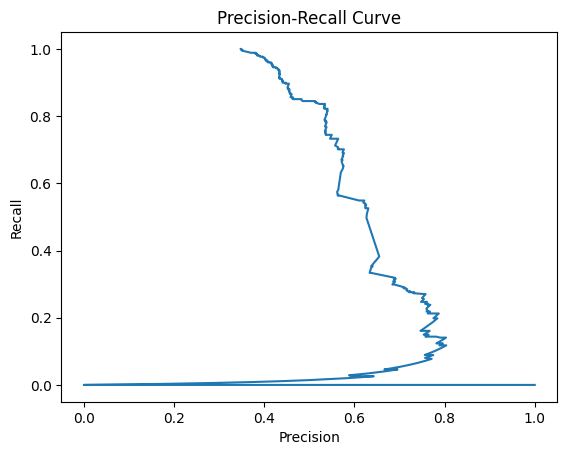

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

y_true = y_test
y_scores = np.array(y_pred)

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

plt.plot(precision, recall)

plt.title('Precision-Recall Curve')
plt.ylabel('Recall')
plt.xlabel('Precision')

plt.show()


In [245]:
rnd = np.random.choice(product_pairs.index)

name1=product_pairs.loc[rnd].name1
name2=product_pairs.loc[rnd].name2

#words_in_name = name1.translate(str.maketrans('', '', '_()')).replace('/',' ').lower().split(' ')

s = ""
s += f"target: {product_pairs.loc[rnd].target}\n"
s += f"name1:  {name1}\n"
s += f"name2:  {name2}\n"
name1_attr2 = set(
    [
        word 
        for word in product_pairs.loc[rnd].name1.translate(
            str.maketrans('', '', '_()')
            ).replace('/',' ').lower().split(' ') if any(
                word in sentence 
                for sentence in [
                    ' '.join(l)
                    for l in json.loads(
                        product_pairs.loc[rnd].characteristic_attributes_mapping2.lower()
                    ).values()
                ]
        )
    ]
)
name2_attr1 = set(
    [
        word 
        for word in product_pairs.loc[rnd].name2.translate(
            str.maketrans('', '', '_()')
            ).replace('/',' ').lower().split(' ') if any(
                word in sentence 
                for sentence in [
                    ' '.join(l)
                    for l in json.loads(
                        product_pairs.loc[rnd].characteristic_attributes_mapping1.lower()
                    ).values()
                ]
        )
    ]
)
name2_attr2 = set(
    [
        word 
        for word in product_pairs.loc[rnd].name2.translate(
            str.maketrans('', '', '_()')
        ).replace('/',' ').lower().split(' ') if any(
            word in sentence 
            for sentence in [
                ' '.join(l)
                for l in json.loads(
                    product_pairs.loc[rnd].characteristic_attributes_mapping2.lower()
                ).values()
            ]
        )
    ]
)
name1_attr1 = set([
    word
    for word in product_pairs.loc[rnd].name1.translate(
        str.maketrans('', '', '_()')
    ).replace('/',' ').lower().split(' ') 
        if any(
            word in sentence 
            for sentence in [
                ' '.join(l)
                for l in json.loads(
                    product_pairs.loc[rnd].characteristic_attributes_mapping1.lower()
                ).values()
            ]
        )
])
n1_a1 = sum(
    importance_attr[attr]
    for word in product_pairs.loc[rnd].name1.translate(
        str.maketrans('', '', '_()\n')
    ).replace('/',' ').lower().split(' ') 
        for (attr, value) in json.loads(
                product_pairs.loc[rnd].characteristic_attributes_mapping1.lower()
        ).items() if word in ' '.join(value)
)
n2_a2 = sum(
    importance_attr[attr]
    for word in product_pairs.loc[rnd].name2.translate(
        str.maketrans('', '', '_()\n')
    ).replace('/',' ').lower().split(' ') 
        for (attr, value) in json.loads(
                product_pairs.loc[rnd].characteristic_attributes_mapping2.lower()
        ).items() if word in ' '.join(value)
)
n1_a2 = sum(
    importance_attr[attr]
    for word in product_pairs.loc[rnd].name1.translate(
        str.maketrans('', '', '_()\n')
    ).replace('/',' ').lower().split(' ') 
        for (attr, value) in json.loads(
                product_pairs.loc[rnd].characteristic_attributes_mapping2.lower()
        ).items() if word in ' '.join(value)
)
n2_a1 = sum(
    importance_attr[attr]
    for word in product_pairs.loc[rnd].name2.translate(
        str.maketrans('', '', '_()\n')
    ).replace('/',' ').lower().split(' ') 
        for (attr, value) in json.loads(
                product_pairs.loc[rnd].characteristic_attributes_mapping1.lower()
        ).items() if word in ' '.join(value)
)
name1_attr1 & name1_attr2

s += f"{n1_a1}: name1 & attr1: {name1_attr1}\n"
s += f"{n2_a2}: name2 & attr2: {name2_attr2}\n"
s += f"{n1_a2}: name1 & attr2: {name1_attr2}\n"
s += f"{n2_a1}: name2 & attr1: {name2_attr1}\n"

attr1 = (json.loads(
    product_pairs.loc[rnd].characteristic_attributes_mapping1.lower()
)).items()

attr2 = (json.loads(
    product_pairs.loc[rnd].characteristic_attributes_mapping2.lower()
)).items()

print(s)

#print(f"attr1:", attr1)
#print(f"attr2:", attr2)

target: 1.0
name1:  Аккумулятор для Huawei Y5 II/Honor 5A (HB4342A1RBC)
name2:  Аккумулятор для Huawei Y5 II/Honor 5A (HB4342A1RBC)
0.4145160104477428: name1 & attr1: {'ii', 'y5', 'honor', 'для', '5a', 'huawei', 'аккумулятор'}
0.04947761376910447: name2 & attr2: {'аккумулятор', 'для'}
0.04947761376910447: name1 & attr2: {'аккумулятор', 'для'}
0.4145160104477428: name2 & attr1: {'ii', 'y5', 'honor', 'для', '5a', 'huawei', 'аккумулятор'}



In [210]:
rnd = rnd#np.random.choice(product_pairs.index)

name1=product_pairs.loc[rnd].name1
name2=product_pairs.loc[rnd].name2

#words_in_name = name1.translate(str.maketrans('', '', '_()')).replace('/',' ').lower().split(' ')

s = ""
s += f"target: {product_pairs.loc[rnd].target}\n"
s += f"name1:  {name1}\n"
s += f"name2:  {name2}\n"
name1_attr2 = set(
    [
        word 
        for word in product_pairs.loc[rnd].name1.translate(
            str.maketrans('', '', '_()')
            ).replace('/',' ').lower().split(' ') if any(
                word in sentence 
                for sentence in [
                    ' '.join(l)
                    for l in json.loads(
                        product_pairs.loc[rnd].characteristic_attributes_mapping2.lower()
                    ).values()
                ]
        )
    ]
)
name2_attr1 = set(
    [
        word 
        for word in product_pairs.loc[rnd].name2.translate(
            str.maketrans('', '', '_()')
            ).replace('/',' ').lower().split(' ') if any(
                word in sentence 
                for sentence in [
                    ' '.join(l)
                    for l in json.loads(
                        product_pairs.loc[rnd].characteristic_attributes_mapping1.lower()
                    ).values()
                ]
        )
    ]
)
name2_attr2 = set(
    [
        word 
        for word in product_pairs.loc[rnd].name2.translate(
            str.maketrans('', '', '_()')
        ).replace('/',' ').lower().split(' ') if any(
            word in sentence 
            for sentence in [
                ' '.join(l)
                for l in json.loads(
                    product_pairs.loc[rnd].characteristic_attributes_mapping2.lower()
                ).values()
            ]
        )
    ]
)
name1_attr1 = set([
    word
    for word in product_pairs.loc[rnd].name1.translate(
        str.maketrans('', '', '_()')
    ).replace('/',' ').lower().split(' ') 
        if any(
            word in sentence 
            for sentence in [
                ' '.join(l)
                for l in json.loads(
                    product_pairs.loc[rnd].characteristic_attributes_mapping1.lower()
                ).values()
            ]
        )
])
n1_a1 = {
    word: attr
    for word in product_pairs.loc[rnd].name1.translate(
        str.maketrans('', '', '_()\n')
    ).replace('/',' ').lower().split(' ') 
        for attr in json.loads(
            product_pairs.loc[rnd].characteristic_attributes_mapping1.lower()
        ) if word in json.loads(
                product_pairs.loc[rnd].characteristic_attributes_mapping1.lower()
        )[attr]
}
n2_a2 = {
    word: attr
    for word in product_pairs.loc[rnd].name2.translate(
        str.maketrans('', '', '_()\n')
    ).replace('/',' ').lower().split(' ') 
        for attr in json.loads(
            product_pairs.loc[rnd].characteristic_attributes_mapping2.lower()
        ) if word in json.loads(
                product_pairs.loc[rnd].characteristic_attributes_mapping2.lower()
        )[attr]
}
n1_a2 = [
    (word, attr)
    for word in product_pairs.loc[rnd].name1.translate(
        str.maketrans('', '', '_()\n')
    ).replace('/',' ').lower().split(' ') 
       for (attr, value) in json.loads(
                product_pairs.loc[rnd].characteristic_attributes_mapping2.lower()
        ).items() if word in ' '.join(value)
]
n2_a1 = [
    (word, attr)
    for word in product_pairs.loc[rnd].name2.translate(
        str.maketrans('', '', '_()\n')
    ).replace('/',' ').lower().split(' ') 
        for (attr, value) in json.loads(
                product_pairs.loc[rnd].characteristic_attributes_mapping1.lower()
        ).items() if word in ' '.join(value)
]


s += f"name1 & attr1: {n1_a1}\n"
s += f"name2 & attr2: {n2_a2}\n"
s += f"name1 & attr2: {n1_a2}\n"
s += f"name2 & attr1: {n2_a1}\n"

set(n1_a1) & set(n1_a2)

attr1 = (json.loads(
    product_pairs.loc[rnd].characteristic_attributes_mapping1.lower()
)).items()

attr2 = (json.loads(
    product_pairs.loc[rnd].characteristic_attributes_mapping2.lower()
)).items()

print(s)
print(f"attr1:", attr1)
print(f"attr2:", attr2)

target: 0.0
name1:  Клавиатура для ноутбука Lenovo Legion 5-15IMH05H топкейс
name2:  Клавиатура для ноутбука Lenovo Legion 5-15ITH6 топкейс
name1 & attr1: {'lenovo': 'рекомендовано для'}
name2 & attr2: {}
name1 & attr2: [('клавиатура', 'тип'), ('для', 'тип'), ('ноутбука', 'тип')]
name2 & attr1: [('клавиатура', 'тип'), ('для', 'тип'), ('ноутбука', 'тип'), ('lenovo', 'совместимость'), ('lenovo', 'рекомендовано для'), ('legion', 'совместимость')]

attr1: dict_items([('страна-изготовитель', ['китай']), ('совместимость', ['5cb0z26789<br>legion 5-15imh05h (lenovo) 81y6<br>legion 5-15imh05 (lenovo) 82au<br>legion 5-15arh05h laptop (lenovo) 82b1']), ('рекомендовано для', ['lenovo']), ('тип', ['клавиатура для ноутбука']), ('бренд', ['oem']), ('вес товара, г', ['200']), ('гарантийный срок', ['1 год'])])
attr2: dict_items([('страна-изготовитель', ['китай']), ('бренд', ['iqzip']), ('тип', ['клавиатура для ноутбука'])])


In [ ]:
np.mean(
    [
        name1.lower().split()
        for name1, attr2 in zip(various_pairs.name1,
                                various_pairs.characteristic_attributes_mapping2)
    ]
)

In [ ]:
count_not_matched_attr_for_various_pairs = collections.Counter(
    attr_name 
    if (
        (
            (' '.join(json.loads(attributes1.lower())[attr_name])) != (
             ' '.join(json.loads(attributes2.lower())[attr_name]))
        ) and (
            cosine_similarity(
                *vectorizer.fit_transform(
                    [
                        ' '.join(json.loads(attributes1.lower())[attr_name]) + 'tr',
                        ' '.join(json.loads(attributes2.lower())[attr_name]) + 'tr'
                    ]
                )
            ) < 0.5
        )
    ) else 'matched'
    for (attributes1, attributes2) in zip(various_pairs.characteristic_attributes_mapping1, 
                                          various_pairs.characteristic_attributes_mapping2)
        for attr_name in set(json.loads(attributes1.lower())) & set(json.loads(attributes2.lower()))
)

In [ ]:
del count_not_matched_attr_for_various_pairs['matched']

In [ ]:
%%time
count_not_matched_attr_for_ident_pairs = collections.Counter(
    attr_name 
      if (
        (
            (' '.join(json.loads(attributes1.lower())[attr_name])) != (
             ' '.join(json.loads(attributes2.lower())[attr_name]))
        ) and (
            cosine_similarity(
                *vectorizer.fit_transform(
                    [
                        ' '.join(json.loads(attributes1.lower())[attr_name]) + 'tr',
                        ' '.join(json.loads(attributes2.lower())[attr_name]) + 'tr'
                    ]
                )
            ) < 0.5
        )
    ) else 'matched'

    for (attributes1, attributes2) in zip(identcial_pairs.characteristic_attributes_mapping1, 
                                          identcial_pairs.characteristic_attributes_mapping2)
        for attr_name in set(json.loads(attributes1.lower())) & set(json.loads(attributes2.lower()))
)

In [ ]:
del count_not_matched_attr_for_ident_pairs['matched']

In [ ]:
%%time
count_not_matched_attr_for_ident_pairs_norm = {
    attr: freq / attr_freq[attr]
    for attr, freq in count_not_matched_attr_for_indent_pairs.items()
}
count_not_matched_attr_for_ident_pairs_norm = dict(
    sorted(count_not_matched_attr_for_ident_pairs_norm.items(),
           key=lambda x: x[1],
           reverse=True)
)
count_not_matched_attr_for_various_pairs_norm = {
    attr: freq / attr_freq[attr]
    for attr, freq in count_not_matched_attr_for_various_pairs.items()
}
count_not_matched_attr_for_various_pairs_norm = dict(
    sorted(count_not_matched_attr_for_various_pairs_norm.items(),
           key=lambda x: x[1],
           reverse=True)
)

In [ ]:
set(list(count_not_matched_attr_for_various_pairs_norm.keys())[:50]) & set(list(count_not_matched_attr_for_ident_pairs_norm.keys())[:50])

In [ ]:
fig, (ax) = plt.subplots(1, 1, figsize=(20, 10))

ax.barh(
    list(count_not_matched_attr_for_indent_pairs_norm.keys())[:50], 
    list(count_not_matched_attr_for_indent_pairs_norm.values())[:50]
)
fig.savefig('./count_not_matched_attr_for_indent_pairs_norm.png')

fig2, (ax2) = plt.subplots(1, 1, figsize=(20, 10))

ax2.barh(
    list(count_not_matched_attr_for_various_pairs_norm.keys())[:50], 
    list(count_not_matched_attr_for_various_pairs_norm.values())[:50]
)
fig2.savefig('./count_not_matched_attr_for_various_pairs_norm.png')

In [ ]:
with open('count_not_matched_attr_for_various_pairs.json', 'w') as f:
    json.dump(count_not_matched_attr_for_various_pairs, f, sort_keys=True)

In [ ]:
with open('count_not_matched_attr_for_indent_pairs.json', 'w') as f:
    json.dump(count_not_matched_attr_for_indent_pairs, f, sort_keys=True)

In [ ]:
docs = (
    ' '.join(json.loads(products_all.loc[i].characteristic_attributes_mapping.lower())[attr])
    for i in products_all.index
        for attr in json.loads(products_all.loc[i].characteristic_attributes_mapping.lower())
)

In [ ]:

rnd = np.random.choice(various_pairs.index)

attrs = set(json.loads(product_pairs.loc[rnd].characteristic_attributes_mapping1.lower())) & set(
    json.loads(product_pairs.loc[rnd].characteristic_attributes_mapping2.lower())
)

if any(attrs):

    vectorizer = TfidfVectorizer()
    a = {
        attr:  cosine_similarity(
            *vectorizer.fit_transform(
                [
                    ' '.join(json.loads(product_pairs.loc[rnd].characteristic_attributes_mapping1.lower())[attr]),
                    ' '.join(json.loads(product_pairs.loc[rnd].characteristic_attributes_mapping2.lower())[attr])
                ]
            )
        ) for attr in attrs if len(
            ' '.join(json.loads(product_pairs.loc[rnd].characteristic_attributes_mapping1.lower())[attr])
        ) > 3
    }

    
a

In [40]:
cosine_similarity(
    *TfidfVectorizer(
        stop_words=[],
        min_df=0.1,
        max_df=0.2
    ).fit_transform(['3 гб', '2 гб'])
)

ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [ ]:
    vectorizer = TfidfVectorizer(min_df=0.6)

    for attr in attrs:
        print(' '.join(json.loads(identcial_pairs.loc[rnd].characteristic_attributes_mapping1.lower())[attr]), '+++',
              ' '.join(json.loads(identcial_pairs.loc[rnd].characteristic_attributes_mapping2.lower())[attr]))
        print(vectorizer.fit_transform(
                [
                    ' '.join(json.loads(identcial_pairs.loc[rnd].characteristic_attributes_mapping1.lower())[attr]),
                    ' '.join(json.loads(identcial_pairs.loc[rnd].characteristic_attributes_mapping2.lower())[attr])
                ]
            ))
